In [23]:
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
import gym
%matplotlib inline 
import matplotlib.pyplot as plt

In [24]:
env = gym.make("CartPole-v1")
input_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

model =nn.Sequential(nn.Linear(input_dim,32),
                     nn.ReLU(),
                     nn.Linear(32,16),
                     nn.ReLU(),
                     nn.Linear(16,n_actions))
model_target = copy.deepcopy(model)

loss_fn = nn.MSELoss()

Learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(),lr= Learning_rate)

In [25]:
def learning_phase(exprience_replay_buffer,target_update,minibatch_size = 32):
    global model_target
    minibatch = np.random.choice(exprience_replay_buffer, minibatch_size ,replace = True)
    s = np.array(list(map(lambda x:x['s'] , minibatch)))
    a = np.array(list(map(lambda x:x['a'] , minibatch)))
    r = np.array(list(map(lambda x:x['r'] , minibatch)))

    sprime = np.array(list(map(lambda x:x['sprime'] , minibatch)))
    done = np.array(list(map(lambda x:x['done'] , minibatch)))
    if target_update == True:
        model_target = copy.deepcopy(model)

    q_s = model(torch.tensor(s).float())
    q_sprime = model_target(torch.tensor(sprime).float())
    q_s_target = q_s.detach().clone()
    
    
    for i,(s1,a1,r1,q_sprime1,done1) in enumerate(zip(s,a,r,q_sprime,done)):
        if not done1: target = r1 + gamma * torch.max(q_sprime1)
        else:target = r1
        q_s_target[i][a1] = target
            
    optimizer.zero_grad()
    loss = loss_fn(q_s , q_s_target)
    loss.backward()
    optimizer.step()
            

In [27]:
r_sums = []
replay_memory = []
mem_max_size = 120000
n_episodes = 1000
gamma = 0.95
epsilon = 1
minibatch_size = 32
for n in range(n_episodes):
    s = env.reset()
    done = False
    r_sum = 0
    flag = 1
    while not done:
        q_s = model(torch.tensor(s).float())
        if np.random.random() < epsilon :
            a = env.action_space.sample()
        else:
            a = np.argmax(q_s.detach().numpy())
        sprime,r,done,info = env.step(a)
        r_sum += r
        if len(replay_memory) > mem_max_size:
            replay_memory.pop(0)
        replay_memory.append({"s":s,"a":a,"r":r,"sprime":sprime,"done":done})
        s = sprime
        if n%1 == 0 and flag == 1:
            flag = 0 
            target_update = True
        else:
            target_update = False   
        learning_phase(replay_memory,target_update,minibatch_size = minibatch_size)
    if epsilon > 0.1:
        epsilon -= 0.001
    r_sums.append(r_sum)
    if ((n+1)%100)==0:
      print("Episode %d: %f" %(n+1 , r_sum))
        

Episode 100: 33.000000
Episode 200: 64.000000
Episode 300: 66.000000
Episode 400: 48.000000
Episode 500: 89.000000
Episode 600: 29.000000
Episode 700: 26.000000
Episode 800: 35.000000
Episode 900: 112.000000
Episode 1000: 143.000000


Text(0, 0.5, 'Reward value')

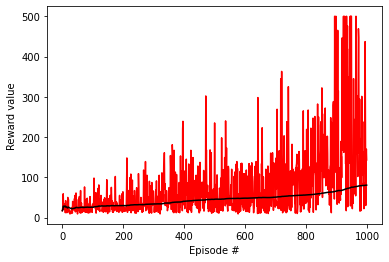

In [28]:
avg = []
temp = r_sums[0]
j = 2
for i in r_sums:
    temp += i
    avg.append(temp/j)
    j+=1
plt.plot(r_sums,color="red")
plt.plot(avg,color="black")
plt.xlabel("Episode #")
plt.ylabel("Reward value")